In [5]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import os
%matplotlib inline

In [6]:
# assuming that the names have been downloaded
if not os.path.exists('names.txt'):
    # download the names.txt file from github
    !wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

with open('names.txt','r') as h:
    words = [w.rstrip() for w in h.readlines()]

print(words[:8])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
32033


In [7]:
chars = sorted(set(''.join(words)))
chars = ['.']+chars

#
# same result as two rows above as '.' is less than any [a-z] or [0-9]
# chars = sorted(set('.'.join(words))):
# print('a' > '.')
# (True)

# same:
#chars = ['.']+[*chars]

N = len(chars)
print(f"\nTotal characters: {N=}\n")

stoi = { s:i for i,s in enumerate(chars)}
itos = { i:s for s,i in stoi.items()}
print(itos)

encode = lambda c : stoi[c]
decode = lambda i : itos[i]

print(encode('a'))
print(decode(1))


Total characters: N=27

{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
1
a


In [8]:
embed_dim_default=10
n_hidden_default=200
block_size = 3 # context length 

In [35]:
def model_init(embed_dim = embed_dim_default, n_hidden = n_hidden_default, verbose=True):
    #
    #  vocab_size is defaulted to 27 as this is the English char set plus '.'
    #
    vocab_size=27
    
    g = torch.Generator().manual_seed(2147483647)
    
    #  embed_dim (10-dim) embedding for characters:
    C = torch.randn((vocab_size, embed_dim), generator=g) # 27x10

    # 3 neurons in the first layer x embed_dim=10 dim in each neuron = 30;
    # are mapped to the "processing layer" of size n_hidden_default (200):
    W1 = torch.randn((3*embed_dim, n_hidden), generator=g)
    b1 = torch.randn(n_hidden, generator=g)

    # map the n_hidden-dim processing layer back to the tokens (vocab_size)
    # to get the prediction:
    W2 = torch.randn((n_hidden, vocab_size), generator=g)
    b2 = torch.randn(vocab_size, generator=g)

    parameters = [C, W1, b1, W2, b2]
    for p in parameters:
        p.requires_grad = True
        
    total_parameters = sum([p.nelement() for p in parameters])
    
    if verbose:
        print(f"{total_parameters = }")
        
    return parameters


def build_dataset(words):
    
    X, Y = [], []
    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = encode(ch)
            X.append(context)
            Y.append(ix)
            context = context[1:]+[ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


@torch.no_grad()
def split_loss(params, split):
    [C, W1, b1, W2, b2] = params
    
    x,y = {'train': (Xtr, Ytr),
          'val': (Xval, Yval),
          'test': (Xte, Yte)}[split]

# no longer needed because of the decorator
#     with torch.no_grad(): 
    emb = C[x]
    d = emb.shape[1]*emb.shape[2]
    h = torch.tanh(emb.view(-1,d) @ W1 + b1)
    logits = h @ W2 + b2
    logits.shape
    loss = F.cross_entropy(logits, y)

    return loss.item()

    
def backward_loss(X, Y, C, W1, b1, W2, b2):
    
    emb = C[X]
    d = emb.shape[1] * emb.shape[2]
    h = torch.tanh(emb.view(-1,d) @ W1 + b1)
    logits = h @ W2 + b2
    logits.shape
    loss = F.cross_entropy(logits, Y)
    
    for p in parameters:
        p.grad = None
    
    loss.backward()

    return loss


def forward_pass(context, parameters):
    
    C, W1, b1, W2, b2 = parameters
    emb = C[torch.tensor([context])] # (1,block_size,10)
    
    # NOTE:
    # emb = C[torch.tensor(context)] 
    # 
    # would instead result in torch.Size([3, 10])
    #
    # print(emb.shape)
    h = torch.tanh(emb.view(1,-1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    
    return probs


def generate_sample(n, parameters):
    
    block_size=3
    g = torch.Generator().manual_seed(2147483647 + 10)
     
    samples = []
    for _ in range(n):
        
        out=[]
        context = [0] * block_size # initialize with all ...
        while True:
            # forward pass
            probs = forward_pass(context, parameters)
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            out.append(decode(ix))
            context = context[1:] + [ix]
            
            if ix == 0:
                break
    
        samples.append(''.join(out))
        
    return samples

In [10]:
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

random.seed(42)
random.shuffle(words)

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [11]:
#
# step over a bunch of learning rates in log-space
#
lre = torch.linspace(-3,0,1000)
lrs = 10**lre

S = lre.shape[0]

loss_v = torch.zeros(S)
parameters = model_init()

total_parameters = 11897


In [12]:
trials = 10
for step in range(S):
    lr = lrs[step]
    ll = torch.zeros(trials)
    for trial in range(trials):
    
        ix = torch.randint(0, Xtr.shape[0], (32,))
        loss = backward_loss(Xtr[ix], Ytr[ix], *parameters)
        
        for p in parameters:
            p.data -= lr*p.grad
            
        ll[trial] = loss.item()

    loss_v[step] = ll.mean()

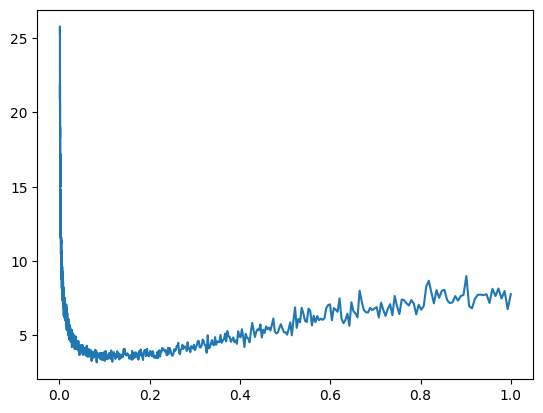

In [13]:
plt.plot(lrs, loss_v)

In [14]:
#
# step over a bunch of learning rates in log-space
#
lre = torch.linspace(-1.2,-0.2,1000)
lrs = 10**lre

S = lre.shape[0]

loss_v = torch.zeros(S)
parameters = model_init()

total_parameters = 11897


In [15]:
# make a single step
trials = 2
for step in range(S):
    lr = lrs[step]
    ll = torch.zeros(trials)
    for trial in range(trials):
    
        ix = torch.randint(0, Xtr.shape[0], (32,))
        loss = backward_loss(Xtr[ix], Ytr[ix], *parameters)
        
        for p in parameters:
            p.data -= lr*p.grad
         
        # store current loss value for the given batch
        # (defined by a random ix (32 values))
        ll[trial] = loss.item()

    loss_v[step] = ll.mean()

In [16]:
ix = torch.randint(0, Xtr.shape[0], (32,))
loss = backward_loss(Xtr[ix], Ytr[ix], *parameters)
print(f"before the gradient step: {loss.item() = }")

for p in parameters:
    p.data -= lr*p.grad
    # this will fail:
    # p -= lr*p.grad 
    # as p requires grad and cannot be modified in-place
    # but .data can, isn't this a bit odd?
    
print(f"after the gradient step with {lr = }, {loss.item() = }")

loss = backward_loss(Xtr[ix], Ytr[ix], *parameters)
print(f"after the gradient step with {lr = }, and loss.backward(): {loss.item() = }")

before the gradient step: loss.item() = 6.193933963775635
after the gradient step with lr = tensor(0.6310), loss.item() = 6.193933963775635
after the gradient step with lr = tensor(0.6310), and loss.backward(): loss.item() = 4.489500999450684


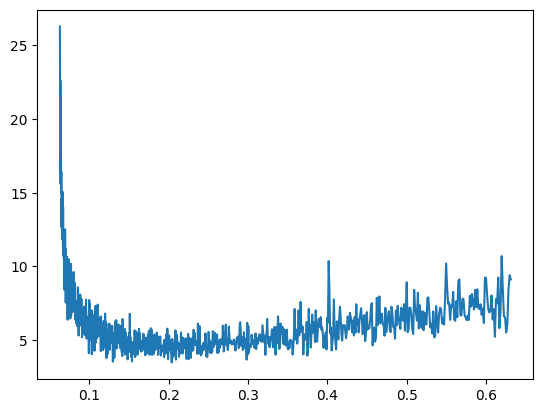

In [17]:
plt.plot(lrs, loss_v)

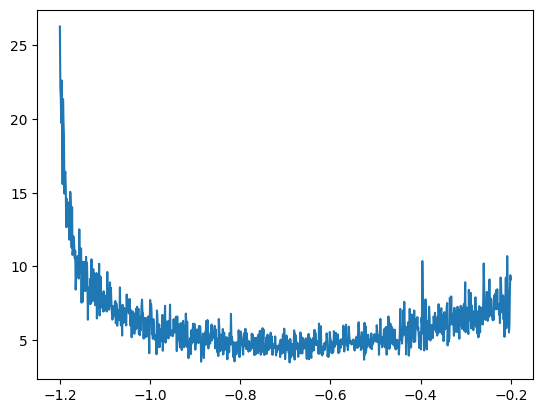

In [18]:
plt.plot(lre, loss_v)

In [45]:
C, W1, b1, W2, b2 = parameters = model_init()

total_parameters = 11897


In [46]:
Steps = 200000
batch_size=32

for step in range(Steps):

    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    emb = C[Xtr[ix]]    
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix]) # (27, 1)
    
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    if step % int(Steps/10) == 0:
        print(f"{step = }, loss = {loss.item()}")
    lr = 0.1 if step < 100000 else 0.01 if step < 200000 else 0.001
    for p in parameters:
        p.data -= lr*p.grad
    
print(f"loss = {loss.item()}")
print(split_loss(parameters, 'val'))

step = 0, loss = 23.812883377075195
step = 20000, loss = 2.5562736988067627
step = 40000, loss = 2.391641616821289
step = 60000, loss = 2.1644539833068848
step = 80000, loss = 2.4277102947235107
step = 100000, loss = 2.5233166217803955
step = 120000, loss = 2.178238868713379
step = 140000, loss = 2.019855499267578
step = 160000, loss = 2.115950345993042
step = 180000, loss = 2.3109323978424072
loss = 2.149044990539551
2.1674976348876953


In [47]:
for split in ['train', 'val', 'test']:
    print(f"{split}:\t{split_loss(parameters, split)}")

train:	2.1229662895202637
val:	2.1674976348876953
test:	2.164400339126587


In [48]:
print('\n'.join(generate_sample(5, parameters)))

carlah.
amelle.
khy.
mili.
taty.


In [53]:
# Initialization is a suspect as the loss function is 'mean negative log-probability' 
# so if all 27 characters are equally likely at the beginning we expect -log(1/27):

-torch.tensor(1/27).log()

tensor(3.2958)

In [71]:
logits = torch.zeros(4)
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
print(f"{loss}\n")

g = torch.Generator().manual_seed(1111)
logits = torch.randn(4, generator=g)
print("Best bucket is 0, but 2 is not too bad:")
print(logits)
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
print(f"{loss}\n")

factor=20
logits = logits*factor
print(f"Best bucket is 0, but 2 has been greatly worsened by multiplyin by a large constant ({factor}):")
print(logits)
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
print(f"{loss}")

1.3862943649291992

Best bucket is 0, but 2 is not too bad:
tensor([-0.4078, -0.9385, -1.2721, -1.5061])
1.7157557010650635

Best bucket is 0, but 2 has been greatly worsened by multiplyin by a large constant (20):
tensor([ -8.1553, -18.7703, -25.4426, -30.1223])
17.287315368652344


In [187]:
print('\n'.join(generate_sample(20, parameters)))

carlah.
ambrie.
khi.
mili.
taty.
haceysa.
jazonte.
den.
art.
kaeli.
nellara.
chaiir.
kaleig.
halma.
din.
quint.
sulie.
alianni.
wajelogiearynix.
kaeliighan.


In [78]:
#
# changing initialization to improve the starting point of training:
#
def model_init(embed_dim = embed_dim_default, n_hidden = n_hidden_default, verbose=True):
    #
    #  vocab_size is defaulted to 27 as this is the English char set plus '.'
    #
    vocab_size=27
    
    g = torch.Generator().manual_seed(2147483647)
    
    #  embed_dim (10-dim) embedding for characters:
    C = torch.randn((vocab_size, embed_dim), generator=g) # 27x10

    # 3 neurons in the first layer x embed_dim=10 dim in each neuron = 30;
    # are mapped to the "processing layer" of size n_hidden_default (200):
    W1 = torch.randn((3*embed_dim, n_hidden), generator=g)
    b1 = torch.randn(n_hidden, generator=g)

    # --> Don't introduce random bias (b2) and scaling (W2) on 0-th step
    # --> as logits at the last layer are calculated as
    # --> input @ W2 + b2
    
    # map the n_hidden-dim processing layer back to the tokens (vocab_size)
    # to get the prediction:
    W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # shouldn't be 0 (!!!)
    
    b2 = torch.randn(vocab_size, generator=g) * 0

    parameters = [C, W1, b1, W2, b2]
    for p in parameters:
        p.requires_grad = True
        
    total_parameters = sum([p.nelement() for p in parameters])
    
    if verbose:
        print(f"{total_parameters = }")
        
    return parameters

In [80]:
C, W1, b1, W2, b2 = parameters = model_init()

total_parameters = 11897


In [83]:
Steps = 200000
batch_size=32
lossi = []
for step in range(Steps):

    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    emb = C[Xtr[ix]]    
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix]) # (27, 1)
    
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    if step % int(Steps/10) == 0:
        print(f"{step = }, loss = {loss.item()}")
    lr = 0.1 if step < 100000 else 0.01 if step < 200000 else 0.001
    for p in parameters:
        p.data -= lr*p.grad
        
    lossi.append(loss.log10().item())

    
print(f"loss = {loss.item()}")
print(split_loss(parameters, 'val'))

step = 0, loss = 2.2018842697143555
step = 20000, loss = 2.1751670837402344
step = 40000, loss = 2.339163303375244
step = 60000, loss = 2.4004080295562744
step = 80000, loss = 1.8991283178329468
step = 100000, loss = 2.5459859371185303
step = 120000, loss = 1.9992246627807617
step = 140000, loss = 2.137185573577881
step = 160000, loss = 2.1483044624328613
step = 180000, loss = 2.2888026237487793
loss = 2.1132850646972656
2.1221635341644287


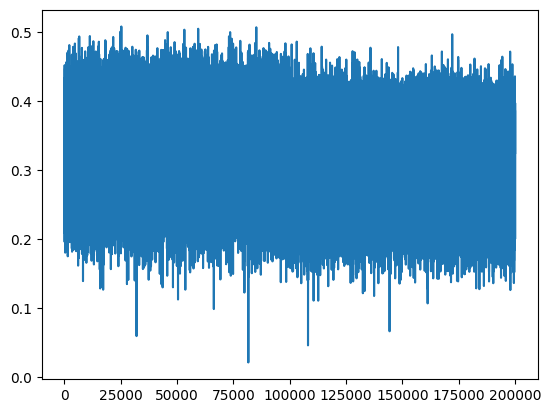

In [84]:
plt.plot(lossi)

In [85]:
for split in ['train', 'val', 'test']:
    print(f"{split}:\t{split_loss(parameters, split)}")

train:	2.0477850437164307
val:	2.1221635341644287
test:	2.122493267059326


In [102]:
# look at initalization of the hidden layer (h-values):
C, W1, b1, W2, b2 = parameters = model_init()

Steps = 200000
batch_size=32
lossi = []
for step in range(Steps):

    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    # Xtr.shape is (#samples in training, 3)
    # Xb.shape is (32,3)
    
    # C.shape = (27,10): individual character embeddings for all characters 
    #    (rows are as we multiply X @ C, where X in this case are 1-hot row vectors)
    
    # shape of this is not obvious; indexing by tensors
    emb = C[Xb] # (32, 3, 10) 
    
    #h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact) # hidden layer
    
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb) # (27, 1)
    
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    if step % int(Steps/10) == 0:
        print(f"{step = }, loss = {loss.item()}")
    lr = 0.1 if step < 100000 else 0.01 if step < 200000 else 0.001
    for p in parameters:
        p.data -= lr*p.grad
        
    lossi.append(loss.log10().item())
    break

    
print(f"loss = {loss.item()}")
print(split_loss(parameters, 'val'))

total_parameters = 11897
step = 0, loss = 3.2788820266723633
loss = 3.2788820266723633
3.1849589347839355


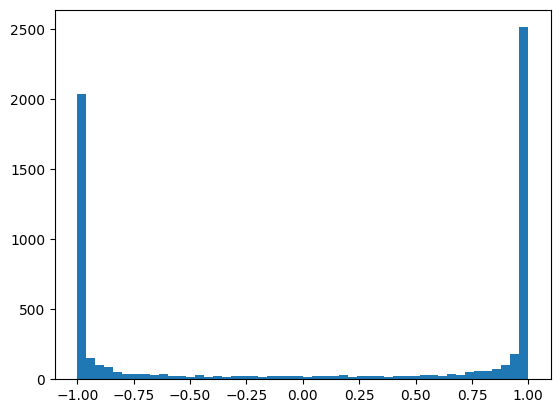

In [94]:
plt.hist(h.view(-1).tolist(), 50); # 50 bins

# lots of +-1:

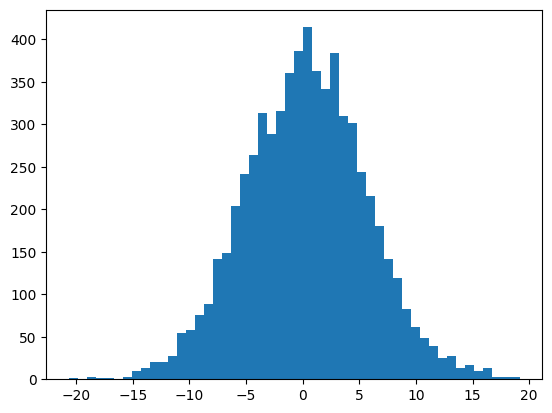

In [105]:
plt.hist(hpreact.view(-1).tolist(), 50);

32
tensor([-1.0000, -1.0000, -0.9987, -1.0000,  0.9412,  0.5567, -0.9092, -1.0000,
        -0.9948, -1.0000, -1.0000, -1.0000, -1.0000,  0.2362, -1.0000, -1.0000,
         0.9412,  0.9923,  0.9971,  1.0000,  0.9934, -1.0000, -0.9998, -0.9989,
        -0.9757, -0.7896, -1.0000, -1.0000, -0.9810,  1.0000,  0.9055, -1.0000],
       grad_fn=<SelectBackward0>) 

tensor([1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 1, 0, 1, 0, 1]) 



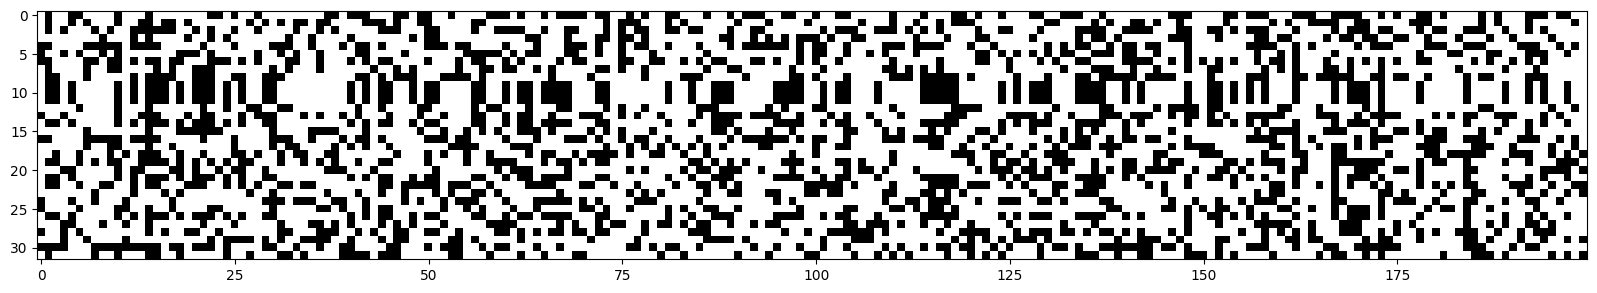

In [120]:
# dead neurons correspond to completely white columns (all connections to this neuron are close to 1)
print(h.shape[0])
#
# connections to a given neuron are given by the second index (h[:,j]) as the output is 
# j-th 1-hot-row @ h = j-th column
#
# same happens if we multipy from the right as input is now coded as 1-hot columns ;)
# 
print(h[:,0],'\n')
print((h[:,0].abs() > 0.99).to(int), '\n')
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

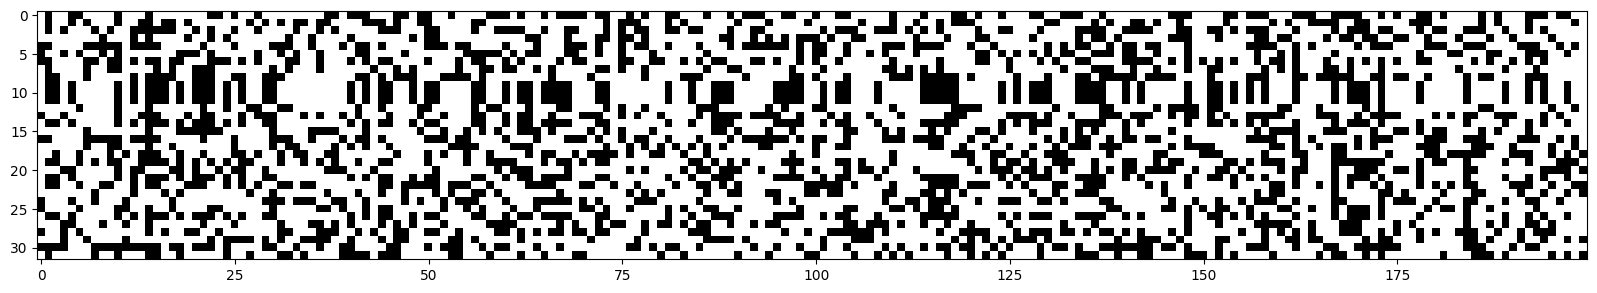

In [123]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray') # what is interpolation doing above?

In [135]:
#
# changing initialization to improve the starting point of training:
#
def model_init(embed_dim = embed_dim_default, n_hidden = n_hidden_default, verbose=True):
    #
    #  vocab_size is defaulted to 27 as this is the English char set plus '.'
    #
    vocab_size=27
    
    g = torch.Generator().manual_seed(2147483647)
    
    #  embed_dim (10-dim) embedding for characters:
    C = torch.randn((vocab_size, embed_dim), generator=g) # 27x10

    # 3 neurons in the first layer x embed_dim=10 dim in each neuron = 30;
    # are mapped to the "processing layer" of size n_hidden_default (200):
    W1 = torch.randn((3*embed_dim, n_hidden), generator=g) * 0.2
    b1 = torch.randn(n_hidden, generator=g) * 0.01 # or exactly 0

    # --> Don't introduce random bias (b2) and scaling (W2) on 0-th step
    # --> as logits at the last layer are calculated as
    # --> input @ W2 + b2
    
    # map the n_hidden-dim processing layer back to the tokens (vocab_size)
    # to get the prediction:
    W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # shouldn't be 0 (!!!)
    
    b2 = torch.randn(vocab_size, generator=g) * 0

    parameters = [C, W1, b1, W2, b2]
    for p in parameters:
        p.requires_grad = True
        
    total_parameters = sum([p.nelement() for p in parameters])
    
    if verbose:
        print(f"{total_parameters = }")
        
    return parameters

In [136]:
# look at initalization of the hidden layer (h-values):
C, W1, b1, W2, b2 = parameters = model_init()

Steps = 200000
batch_size=32
lossi = []
for step in range(Steps):

    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    # Xtr.shape is (#samples in training, 3)
    # Xb.shape is (32,3)
    
    # C.shape = (27,10): individual character embeddings for all characters 
    #    (rows are as we multiply X @ C, where X in this case are 1-hot row vectors)
    
    # shape of this is not obvious; indexing by tensors
    emb = C[Xb] # (32, 3, 10) 
    
    #h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact) # hidden layer
    
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb) # (27, 1)
    
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    if step % int(Steps/10) == 0:
        print(f"{step = }, loss = {loss.item()}")
    lr = 0.1 if step < 100000 else 0.01 if step < 200000 else 0.001
    for p in parameters:
        p.data -= lr*p.grad
        
    lossi.append(loss.log10().item())
    break

    
print(f"loss = {loss.item()}")
print(split_loss(parameters, 'val'))

total_parameters = 11897
step = 0, loss = 3.270495653152466
loss = 3.270495653152466
3.2661681175231934


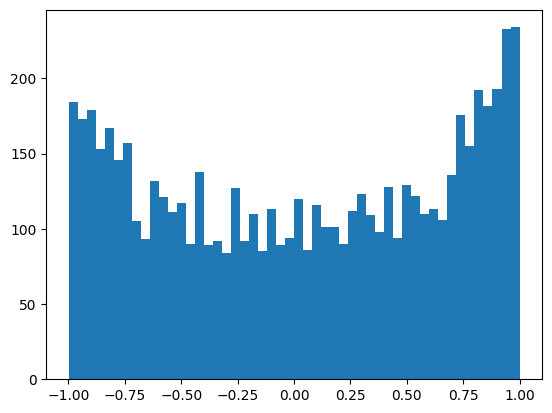

In [137]:
plt.hist(h.view(-1).tolist(), 50); # 50 bins

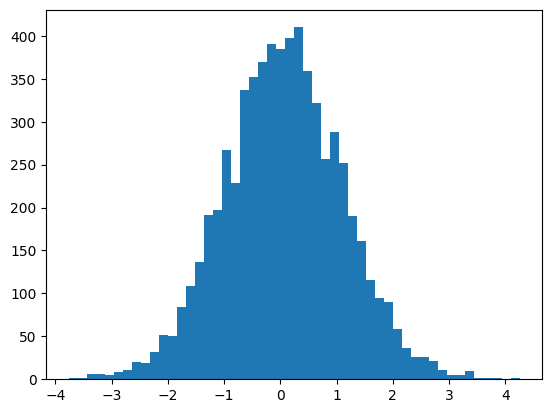

In [138]:
plt.hist(hpreact.view(-1).tolist(), 50);

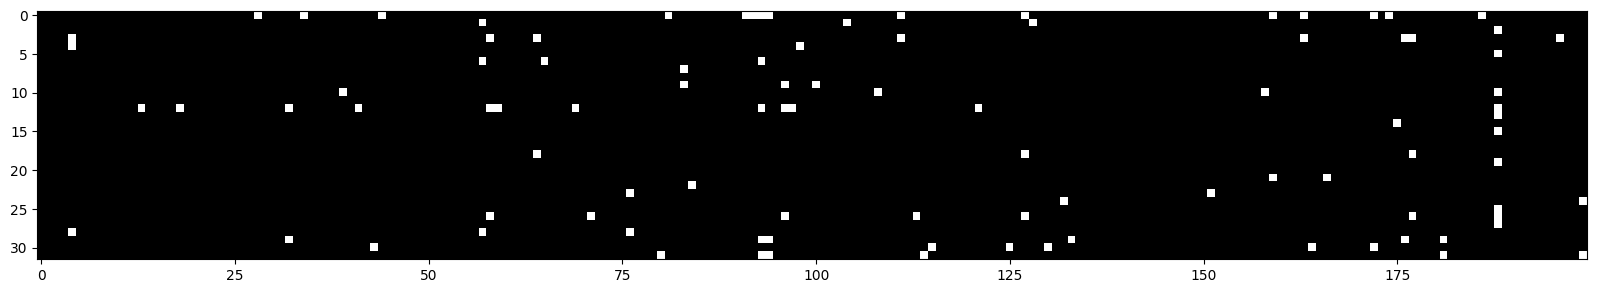

In [139]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

# nothing is white now:

In [140]:
print(h[:,0],'\n')
print((h[:,4].abs() > 0.99).to(int), '\n')

tensor([ 8.1501e-01, -1.1637e-01, -9.1904e-01, -9.2487e-04,  7.3940e-01,
        -9.1904e-01, -6.5306e-01, -9.7243e-01,  3.8850e-01,  8.3376e-01,
         8.4108e-01, -8.4303e-01,  2.7778e-02, -9.1904e-01, -3.1385e-01,
        -9.1904e-01, -9.2440e-01,  6.0966e-01,  8.4353e-01, -9.1904e-01,
        -9.3619e-01,  7.4610e-01,  8.0222e-01, -2.7871e-01,  1.7446e-01,
        -9.1904e-01,  7.3950e-01, -9.1904e-01,  1.3588e-02,  3.1619e-01,
        -8.1327e-01,  9.3189e-01], grad_fn=<SelectBackward0>) 

tensor([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0]) 



In [141]:
# look at initalization of the hidden layer (h-values):
C, W1, b1, W2, b2 = parameters = model_init()

Steps = 200000
batch_size=32
lossi = []
for step in range(Steps):

    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    # Xtr.shape is (#samples in training, 3)
    # Xb.shape is (32,3)
    
    # C.shape = (27,10): individual character embeddings for all characters 
    #    (rows are as we multiply X @ C, where X in this case are 1-hot row vectors)
    
    # shape of this is not obvious; indexing by tensors
    emb = C[Xb] # (32, 3, 10) 
    
    #h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact) # hidden layer
    
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb) # (27, 1)
    
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    if step % int(Steps/10) == 0:
        print(f"{step = }, loss = {loss.item()}")
    lr = 0.1 if step < 100000 else 0.01 if step < 200000 else 0.001
    for p in parameters:
        p.data -= lr*p.grad
        
    lossi.append(loss.log10().item())
    
print(f"loss = {loss.item()}")
print(split_loss(parameters, 'val'))

total_parameters = 11897
step = 0, loss = 3.3052704334259033
step = 20000, loss = 2.189363718032837
step = 40000, loss = 1.9193975925445557
step = 60000, loss = 2.2412123680114746
step = 80000, loss = 2.21340012550354
step = 100000, loss = 1.8801348209381104
step = 120000, loss = 2.3194210529327393
step = 140000, loss = 2.490539312362671
step = 160000, loss = 2.013162612915039
step = 180000, loss = 1.8706262111663818
loss = 2.0798091888427734
2.101078510284424


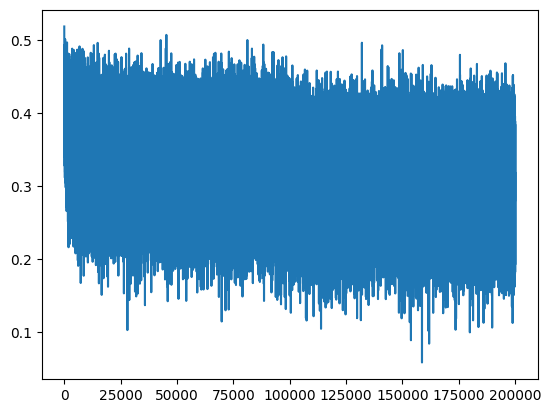

In [142]:
plt.plot(lossi)

In [143]:
for split in ['train', 'val', 'test']:
    print(f"{split}:\t{split_loss(parameters, split)}")

train:	2.0368165969848633
val:	2.101078510284424
test:	2.103663921356201
